In [1]:
import pandas as pd
import spacy
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from math import ceil, floor
import random
from transformers import BertTokenizer, BertModel
from sklearn.cluster import KMeans
import ast
import re
from sklearn.metrics import silhouette_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 855.2 kB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [4]:
# Load the pre-trained medium model from spaCy
nlp = spacy.load('en_core_web_lg')

In [5]:
# Load pre-trained model tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load pre-trained model
model = BertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## Defining Functions

In [6]:
def jitter(value, jitter_amount=0.2):
    return value + random.uniform(-jitter_amount, jitter_amount)

In [7]:
def cosine_similarity(vecA, vecB):
    dot_product = np.dot(vecA, vecB)
    normA = np.linalg.norm(vecA)
    normB = np.linalg.norm(vecB)
    return dot_product / (normA * normB)

In [8]:
# Function to compute the most similar word and its similarity score
def find_most_similar(word_embedding, all_embeddings):
    max_similarity = -1
    most_similar_word = None
    for other_word, other_embedding in all_embeddings.items():
        if not (word_embedding == other_embedding).all():
            similarity = cosine_similarity(word_embedding, other_embedding)
            if similarity > max_similarity:
                max_similarity = similarity
                most_similar_word = other_word
    return most_similar_word, max_similarity

In [9]:
def get_spacy_static_embedding(text):
    doc = nlp(text)
    # Get the vector for the entire document
    return doc.vector

In [10]:
def find_string_index(list_of_strings, string_to_find):
    try:
        return list_of_strings.index(string_to_find)
    except ValueError:
        return -1  # black

In [11]:
# Function to get embeddings
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt')
    outputs = model(**inputs)
    # Get the embeddings for the [CLS] token (sentence embedding)
    return outputs.last_hidden_state[0][0].detach().numpy()

## Reading the data

In [12]:
df = pd.read_csv("drive/MyDrive/k2d/Data/common_entity.csv")
#df = df.head(1000)
df

,ID,name
0,Q100,Boston
1,Q1000,Gabon
2,Q1000219,Kapoor family
3,Q1000592,Tyson Fury
4,Q1001,Mahatma Gandhi
...,...,...
5893,Q9960,Ronald Reagan
5894,Q99670443,Elijah Moore
5895,Q99707767,Aidan Hutchinson
5896,Q99760796,Cole Palmer


## Calculating Embeddings

In [13]:
df['embeddings_trf'] = df['name'].apply(get_bert_embedding)

In [14]:
df.to_csv("drive/MyDrive/entity_embedding.csv", index=False)

In [15]:
# Apply the function to each name in the DataFrame
df['embeddings'] = df['name'].apply(get_spacy_static_embedding)

In [16]:
df.to_csv("drive/MyDrive/entity_embedding.csv", index=False)

In [17]:
# List of subjects
subjects = ["Geography","History","Mathematics","Literature","Computer Science","Biology","Statistics","Physics","Chemistry","Medicine","Economics","Philosophy","Psychology","Music","Cinema","Television","Sport"]
colors = [
    "#1f77b4",  # Blue
    "#ff7f0e",  # Orange
    "#2ca02c",  # Green
    "#d62728",  # Red
    "#9467bd",  # Purple
    "#8c564b",  # Brown
    "#e377c2",  # Pink
    "#7f7f7f",  # Gray
    "#bcbd22",  # Olive
    "#17becf",  # Cyan
    "#aec7e8",  # Light Blue
    "#ffbb78",  # Light Orange
    "#98df8a",  # Light Green
    "#ff9896",  # Light Red
    "#c5b0d5",  # Light Purple
    "#c49c94",  # Light Brown
    "#c7c7c7",   # Light Gray
    "k"
]

## TSNE Static Embedding

In [18]:
# Create a dictionary to hold the embeddings
word_embeddings = {}

# Populate the dictionary
for word in subjects:
    doc = nlp(word)
    word_embeddings[word] = doc.vector

In [19]:
# Find the most similar word and similarity score for each word in the DataFrame
df['most_similar'], df['similarity_score'] = zip(*df['embeddings'].apply(lambda emb: find_most_similar(emb, word_embeddings)))

In [20]:
df_most_similar = df.groupby('most_similar').apply(lambda x: x.nlargest(5, 'similarity_score')).reset_index(drop=True)

In [21]:
# Extract embeddings and labels for the entire DataFrame
embeddings = np.array(df['embeddings'].tolist())
labels = df['name']
most_similar_labels = df['most_similar']

In [22]:
# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(embeddings)

In [23]:
# Create a DataFrame for t-SNE results
tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
tsne_df['label'] = labels
tsne_df['most_similar'] = df['most_similar']

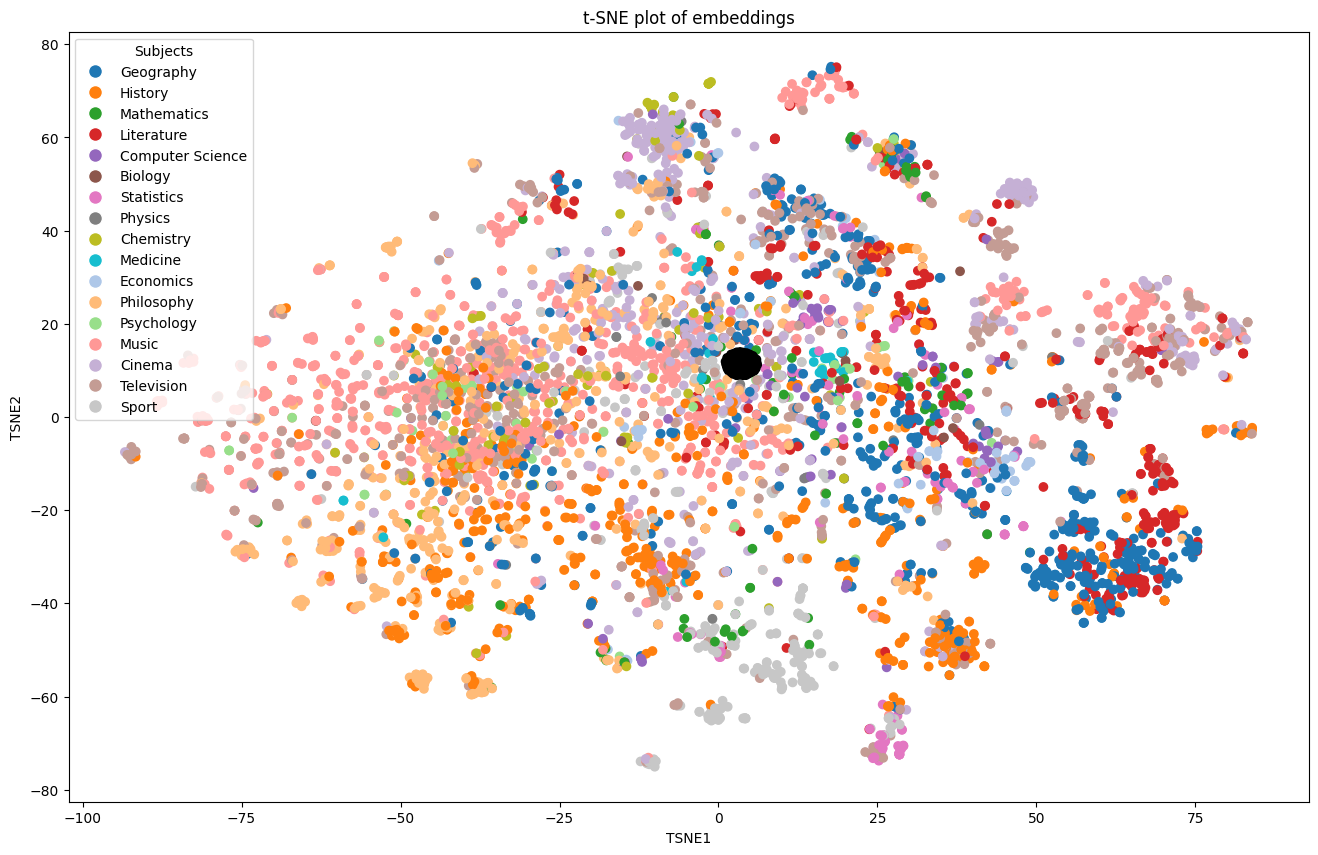

In [24]:
# Plotting
plt.figure(figsize=(16, 10))
colors_dot = tsne_df['most_similar'].apply(lambda x: colors[find_string_index(subjects,x)])

scatter = plt.scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], c=colors_dot)

# Create a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10) for i, label in enumerate(subjects)]
plt.legend(handles, subjects, title="Subjects", loc='best')

plt.title("t-SNE plot of embeddings")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.show()

In [25]:
# Create a DataFrame for t-SNE results
tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
tsne_df['label'] = labels
tsne_df['name'] = df['name']
tsne_df['most_similar'] = most_similar_labels

# Filter the t-SNE results to show only the elements in df_most_similar
tsne_df_subset = tsne_df[tsne_df['label'].isin(df_most_similar['name'])]
tsne_df_subset = tsne_df_subset.reset_index()
tsne_df_subset

,index,TSNE1,TSNE2,label,name,most_similar
0,42,42.968658,-5.546230,Parental Guidance,Parental Guidance,Psychology
1,110,-2.765993,40.848896,Shukla Test,Shukla Test,Physics
2,111,-3.241379,40.144707,Feldman Test,Feldman Test,Chemistry
3,113,-3.339810,40.149368,Landau Test,Landau Test,Physics
4,175,-3.264886,40.685387,Coates Test,Coates Test,Chemistry
...,...,...,...,...,...,...
80,5536,-58.976597,-17.938831,Dr. Death,Dr. Death,Medicine
81,5615,-15.257853,-5.223389,scientist,scientist,Biology
82,5677,42.093468,-3.713464,Space Tracking and Surveillance System,Space Tracking and Surveillance System,Computer Science
83,5752,43.987919,36.560570,television presenter,television presenter,Television


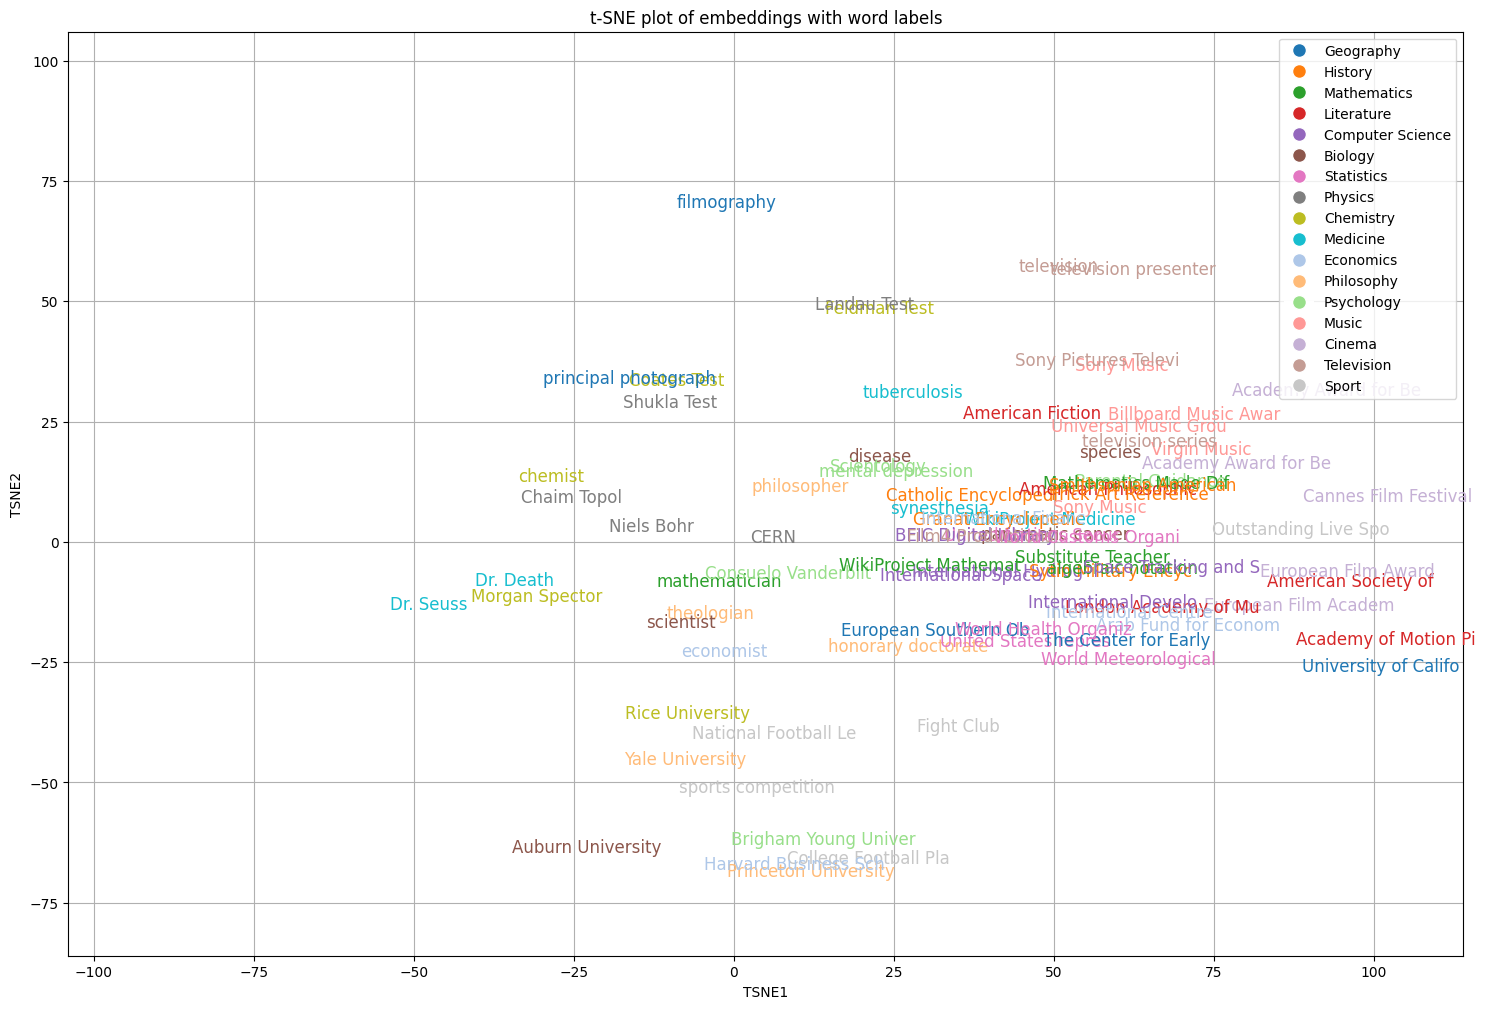

In [26]:
colors_text = tsne_df_subset['most_similar'].apply(lambda x: colors[find_string_index(subjects,x)])

# Plotting
plt.figure(figsize=(18, 12))
for i in range(tsne_df_subset.shape[0]):
    plt.text(jitter(tsne_df_subset['TSNE1'][i], 20), jitter(tsne_df_subset['TSNE2'][i], 20), tsne_df_subset['name'][i][:20], color=colors_text[i], fontsize=12)

# Create a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10) for i, label in enumerate(subjects)]
plt.legend(handles, subjects, loc='best')

plt.title("t-SNE plot of embeddings with word labels")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")

# Set the limits of the plot to ensure the text is visible
plt.xlim(floor(tsne_df['TSNE1'].min()) - 10, ceil(tsne_df['TSNE1'].max() + 30))
plt.ylim(floor(tsne_df['TSNE2'].min()) - 10, ceil(tsne_df['TSNE2'].max() + 30))

plt.grid(True)
plt.show()

## TSNE Transformers

In [27]:
# Create a dictionary to hold the embeddings
word_embeddings = {}

# Populate the dictionary
for word in subjects:
    embedding = get_bert_embedding(word)
    word_embeddings[word] = embedding

In [28]:
# Find the most similar word and similarity score for each word in the DataFrame
df['most_similar_trf'], df['similarity_score_trf'] = zip(*df['embeddings_trf'].apply(lambda emb: find_most_similar(emb, word_embeddings)))

In [29]:
df_most_similar = df.groupby('most_similar_trf').apply(lambda x: x.nlargest(5, 'similarity_score_trf')).reset_index(drop=True)

In [30]:
# Extract embeddings and labels for the entire DataFrame
embeddings = np.array(df['embeddings_trf'].tolist())
labels = df['name']
most_similar_labels = df['most_similar_trf']

In [31]:
# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(embeddings)

In [32]:
# Create a DataFrame for t-SNE results
tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
tsne_df['label'] = labels
tsne_df['most_similar'] = df['most_similar']

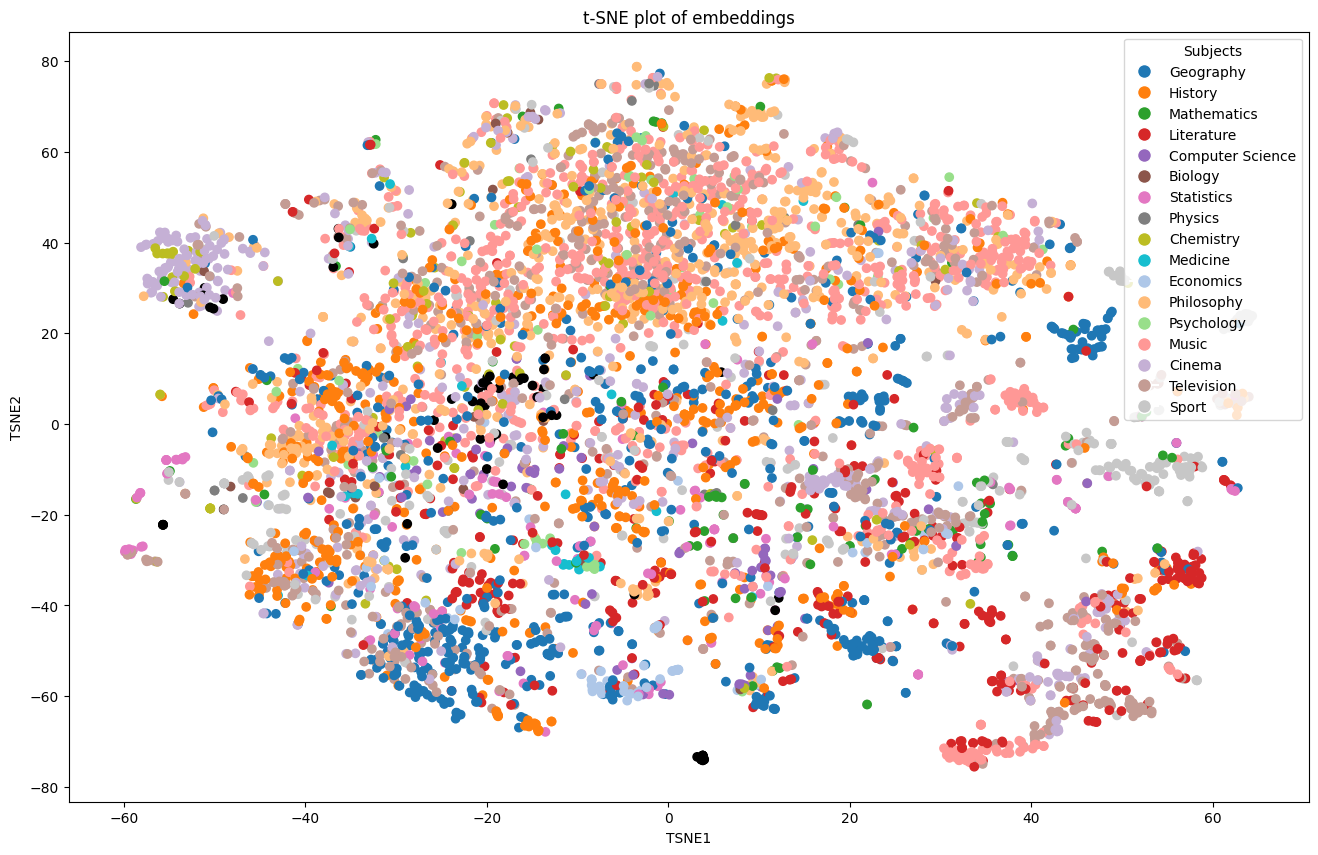

In [33]:
# Plotting
plt.figure(figsize=(16, 10))
colors_dot = tsne_df['most_similar'].apply(lambda x: colors[find_string_index(subjects,x)])

scatter = plt.scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], c=colors_dot)

# Create a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10) for i, label in enumerate(subjects)]
plt.legend(handles, subjects, title="Subjects", loc='best')

plt.title("t-SNE plot of embeddings")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.show()

In [34]:
# Create a DataFrame for t-SNE results
tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
tsne_df['label'] = labels
tsne_df['name'] = df['name']
tsne_df['most_similar'] = most_similar_labels

# Filter the t-SNE results to show only the elements in df_most_similar
tsne_df_subset = tsne_df[tsne_df['label'].isin(df_most_similar['name'])]
tsne_df_subset = tsne_df_subset.reset_index()
tsne_df_subset

,index,TSNE1,TSNE2,label,name,most_similar
0,91,-5.742105,-34.617065,heterosexuality,heterosexuality,Psychology
1,493,32.233719,-33.399185,drum,drum,Biology
2,501,34.458038,-17.495050,karate,karate,Psychology
3,503,16.040852,-14.539548,film,film,Cinema
4,616,7.402522,-38.436169,artificial intelligence,artificial intelligence,Psychology
...,...,...,...,...,...,...
77,5529,-25.698318,-47.759750,Sri Lanka,Sri Lanka,Medicine
78,5575,-25.713778,-47.839470,Thailand,Thailand,Medicine
79,5621,37.372601,-26.709970,defensive end,defensive end,Chemistry
80,5692,-20.549963,-33.086174,Hebrew,Hebrew,Mathematics


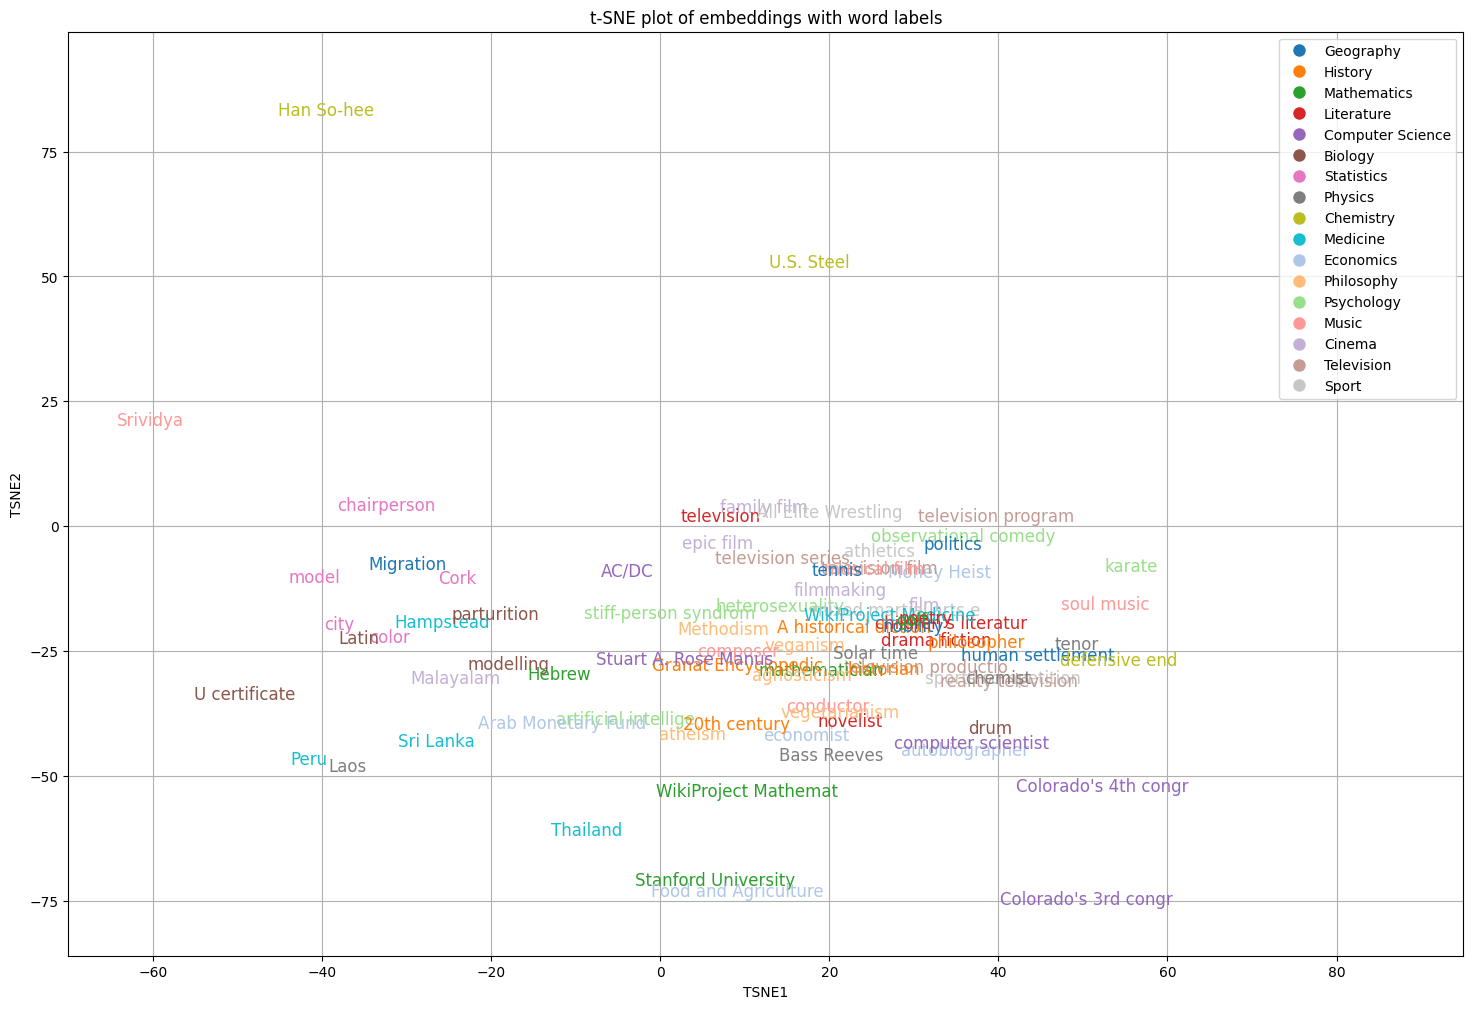

In [35]:
colors_text = tsne_df_subset['most_similar'].apply(lambda x: colors[find_string_index(subjects,x)])

# Plotting
plt.figure(figsize=(18, 12))
for i in range(tsne_df_subset.shape[0]):
    plt.text(jitter(tsne_df_subset['TSNE1'][i], 20), jitter(tsne_df_subset['TSNE2'][i], 20), tsne_df_subset['name'][i][:20], color=colors_text[i], fontsize=12)

# Create a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10) for i, label in enumerate(subjects)]
plt.legend(handles, subjects, loc='best')

plt.title("t-SNE plot of embeddings with word labels")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")

# Set the limits of the plot to ensure the text is visible
plt.xlim(floor(tsne_df['TSNE1'].min()) - 10, ceil(tsne_df['TSNE1'].max() + 30))
plt.ylim(floor(tsne_df['TSNE2'].min()) - 10, ceil(tsne_df['TSNE2'].max() + 20))

plt.grid(True)
plt.show()

In [36]:
df.to_csv("drive/MyDrive/entity_embedding.csv", index=False)

In [37]:
df = pd.read_csv("drive/MyDrive/entity_embedding.csv")

## Clustering of embedding

In [38]:
df['embeddings'] = df['embeddings'].apply(lambda x: np.array(ast.literal_eval(re.sub(r'\s+', ',', x.replace('\n', '')).replace('[,', '['))))

In [39]:
entity_embeddings = np.array(df['embeddings'].tolist())

In [40]:
distortions = []
silhouette_scores = []
K = range(5, 20)  # You can change the range based on what you believe is a reasonable number of clusters

for k in K:
    print(k)
    kmeanModel = KMeans(n_clusters=k, random_state=0)
    kmeanModel.fit(entity_embeddings)
    distortions.append(kmeanModel.inertia_)
    labels = kmeanModel.labels_
    score = silhouette_score(entity_embeddings, labels)
    silhouette_scores.append(score)

5


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


6


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


7


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


8


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


9


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


10


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


11


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


12


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


13


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


14


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


15


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


16


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


17


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


18


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


19


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


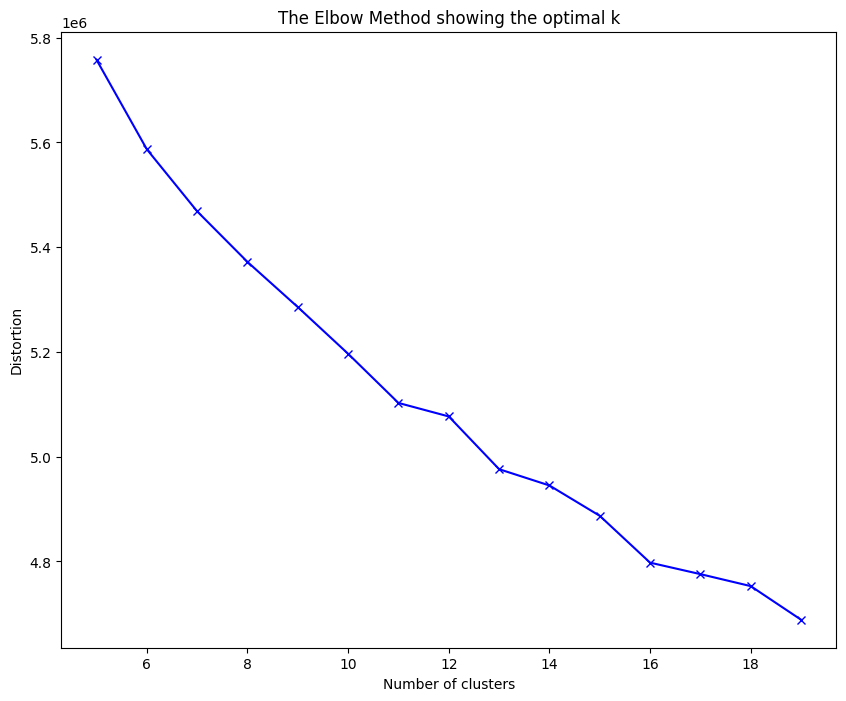

In [41]:
# Plotting the distortions to find the elbow
plt.figure(figsize=(10, 8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

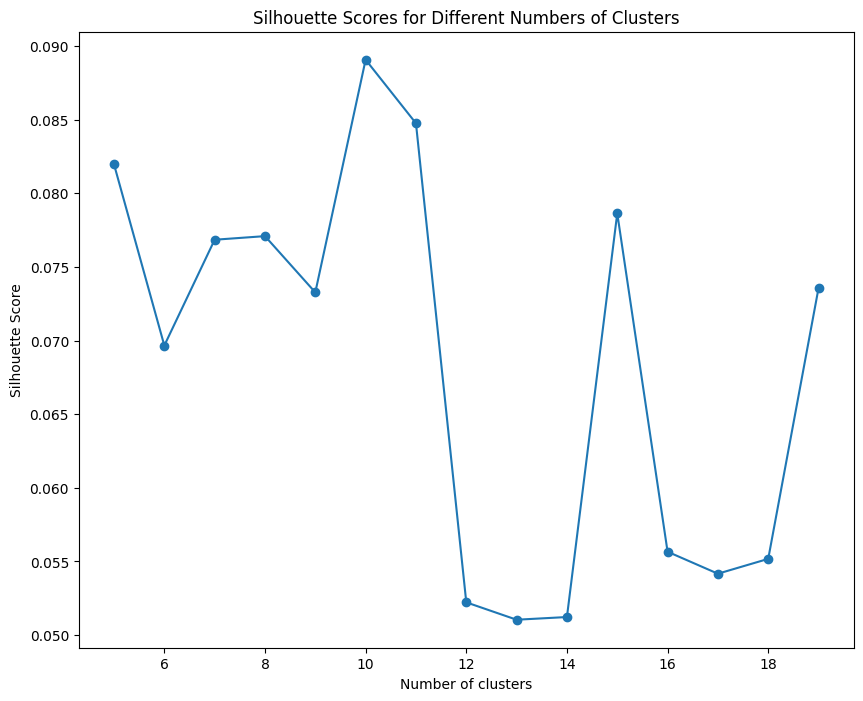

In [42]:
# Plot the results
plt.figure(figsize=(10, 8))
plt.plot(K, silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.show()

In [43]:
k = 15  # replace with your chosen optimal number
kmeans = KMeans(n_clusters=k, random_state=0).fit(entity_embeddings)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [44]:
# Calculate distances from each point to its cluster centroid
distances = np.linalg.norm(entity_embeddings - centroids[labels], axis=1)

In [45]:
# Prepare a DataFrame to store the closest points' names for each cluster
closest_names = []
most_similar = 20

for i in range(k):
    # Find indices of points in cluster 'i'
    indices_in_cluster = np.where(labels == i)[0]

    # Calculate distances of these points to the corresponding centroid
    distances_in_cluster = distances[indices_in_cluster]

    # Get the indices of the 10 points with the smallest distances
    closest_point_indices = np.argsort(distances_in_cluster)[:most_similar]

    # Map these indices back to the original indices in the full dataset
    closest_points_indices_in_full = indices_in_cluster[closest_point_indices]

    # Collect names of these points
    closest_names.append(df.iloc[closest_points_indices_in_full]['name'].values)

# Now `closest_names` contains the names of the 10 closest points for each cluster
for idx, names in enumerate(closest_names):
    print(f"Cluster {idx + 1}:")
    for name in names:
        print(name)
    print("\n")

Cluster 1:
December 17
FSK 16
December 22
December 18
December 21
December 19
December 28
December 23
December 25
FSK 12
December 26
USK 18
December 27
Billboard 21 Under 21
12 certificate
Beacon 23
18 certificate
December 29
15 certificate
December 20


Cluster 2:
Melissa Hoskins
Katherine Jenkins
Denise Richards
Rebecca Wilcox
Pamela Anderson
Matthew Ransley
Brandon Aubrey
Harrison Ruffin Tyler
Craig Bohl
Desmond Wilcox
Natasha Richardson
Toby Stephens
Christopher Biggins
Leslie Carter
Maureen Flavin Sweeney
Keely Shaye Smith
Sinead Matthews
Kurtis Chapman
Daryl Johnston
Stetson Bennett


Cluster 3:
Charlottetown
Annapolis
Philipsburg
Crossroads
Boston Corbett
Greensboro
Jacksonville
Philadelphia
Madison Cawthorn
Virginia Kull
Chattanooga
Georgetown
Scottsdale
Chester Bennington
Sacramento
Lawrence Shankland
Albuquerque
Montgomery
Simsbury
Virginia O'Hanlon


Cluster 4:
United States Penitentiary, Florence ADMAX
Turkmenistan
WikiProject Ukraine
Mauritania
Somaliland
Sytin Military En